# Loading/Preprocessing the Data

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


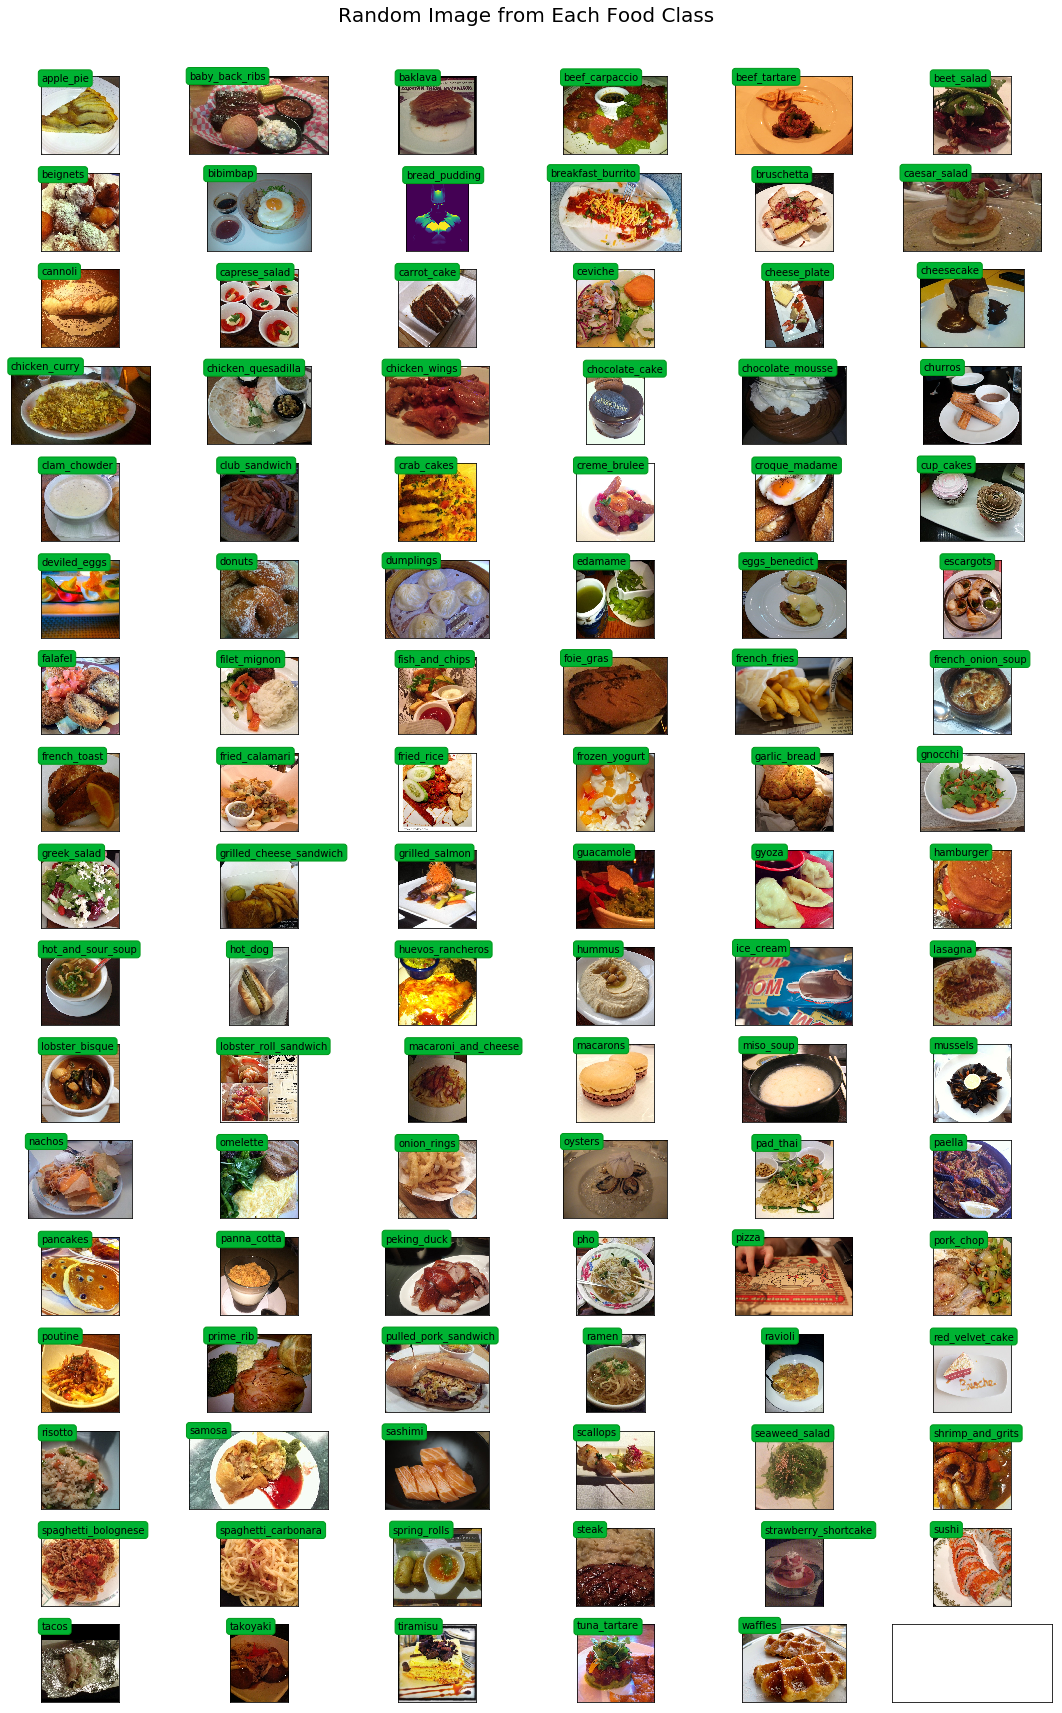

In [6]:
root_dir = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [5]:
# Setup multiprocessing pool
# Do this early, as once images are loaded into memory there will be Errno 12
# http://stackoverflow.com/questions/14749897/python-multiprocessing-memory-usage
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

In [6]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [4]:
# Only split files if haven't already
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [7]:
%%time
import imageio
# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        if subdir in ["ramen", "pho", "pad_thai", "spaghetti_carbonara", "spaghetti_bolognese"]:
            imgs = listdir(join(root, subdir))
            class_ix = class_to_ix[subdir]
            print(i, class_ix, subdir)
            for img_name in imgs:
                img_arr = imageio.imread(join(root, subdir, img_name))
                img_arr_rs = img_arr
                try:
                    w, h, _ = img_arr.shape
                    if w < min_side:
                        wpercent = (min_side/float(w))
                        hsize = int((float(h)*float(wpercent)))
                        #print('new dims:', min_side, hsize)
                        img_arr_rs = skimage.transform.resize(img_arr, (min_side, hsize))
                        resize_count += 1
                    elif h < min_side:
                        hpercent = (min_side/float(h))
                        wsize = int((float(w)*float(hpercent)))
                        #print('new dims:', wsize, min_side)
                        img_arr_rs = skimage.transform.resize(img_arr, (wsize, min_side))
                        resize_count += 1
                    all_imgs.append(img_arr_rs)
                    all_classes.append(class_ix)
                except:
                    print('Skipping bad image: ', subdir, img_name)
                    invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('food-101/test', min_side=299)

9 91 spaghetti_carbonara
Skipping bad image:  spaghetti_carbonara 2333067.jpg
Skipping bad image:  spaghetti_carbonara 2882129.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 720896 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 196608 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_carbonara 2957999.jpg
Skipping bad image:  spaghetti_carbonara 906675.jpg
Skipping bad image:  spaghetti_carbonara 1900436.jpg
Skipping bad image:  spaghetti_carbonara 1566710.jpg
Skipping bad image:  spaghetti_carbonara 3910421.jpg
Skipping bad image:  spaghetti_carbonara 1522638.jpg
46 90 spaghetti_bolognese
Skipping bad image:  spaghetti_bolognese 501894.jpg
Skipping bad image:  spaghetti_bolognese 2002026.jpg
Skipping bad image:  spaghetti_bolognese 3510210.jpg
Skipping bad image:  spaghetti_bolognese 1660402.jpg
Skipping bad image:  spaghetti_bolognese 2068959.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1245184 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_bolognese 1906824.jpg
73 81 ramen
Skipping bad image:  ramen 3357303.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 917504 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2228224 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  ramen 3288667.jpg
Skipping bad image:  ramen 726528.jpg
Skipping bad image:  ramen 3679050.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1310720 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  ramen 1770725.jpg
Skipping bad image:  ramen 3645906.jpg
Skipping bad image:  ramen 3570678.jpg
Skipping bad image:  ramen 2869148.jpg
81 70 pad_thai
Skipping bad image:  pad_thai 2133286.jpg
Skipping bad image:  pad_thai 3923456.jpg
Skipping bad image:  pad_thai 3640370.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3670016 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3735552 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pad_thai 1358765.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3342336 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 102400 bytes but only got 0. Skipping tag 17920
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


Skipping bad image:  pad_thai 3377891.jpg
82 75 pho


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1376256 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33555456 bytes but only got 0. Skipping tag 59392
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3211264 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 983040 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pho 929667.jpg
Skipping bad image:  pho 3873024.jpg
Skipping bad image:  pho 881249.jpg
Skipping bad image:  pho 2234433.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1114112 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262144 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1638400 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 67240448 bytes but only got 189. Skipping tag 48384
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 

Skipping bad image:  pho 1028507.jpg
Skipping bad image:  pho 1337076.jpg
Skipping bad image:  pho 395877.jpg
1216 images loaded
0 images resized
34 images skipped
CPU times: user 4 s, sys: 1.11 s, total: 5.11 s
Wall time: 7.57 s


In [8]:
%%time
X_train, y_train = load_images('food-101/train', min_side=299)

9 91 spaghetti_carbonara
Skipping bad image:  spaghetti_carbonara 3210760.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589824 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_carbonara 59935.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2621440 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


Skipping bad image:  spaghetti_carbonara 2811977.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1900544 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3604480 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1179648 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1769472 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_carbonara 1124356.jpg
Skipping bad image:  spaghetti_carbonara 2829676.jpg
Skipping bad image:  spaghetti_carbonara 2978646.jpg
Skipping bad image:  spaghetti_carbonara 2930419.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1024000 bytes but only got 0. Skipping tag 13056
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 851968 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


46 90 spaghetti_bolognese


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1507328 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_bolognese 2142734.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3145728 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_bolognese 2162105.jpg
Skipping bad image:  spaghetti_bolognese 1816344.jpg
Skipping bad image:  spaghetti_bolognese 3353469.jpg
Skipping bad image:  spaghetti_bolognese 2028065.jpg
Skipping bad image:  spaghetti_bolognese 3888024.jpg
Skipping bad image:  spaghetti_bolognese 385901.jpg
Skipping bad image:  spaghetti_bolognese 3646945.jpg
Skipping bad image:  spaghetti_bolognese 3669898.jpg
Skipping bad image:  spaghetti_bolognese 2568882.jpg
Skipping bad image:  spaghetti_bolognese 2508819.jpg
Skipping bad image:  spaghetti_bolognese 1680506.jpg
Skipping bad image:  spaghetti_bolognese 3078001.jpg
Skipping bad image:  spaghetti_bolognese 936987.jpg
Skipping bad image:  spaghetti_bolognese 3867365.jpg
Skipping bad image:  spaghetti_bolognese 3336806.jpg
Skipping bad image:  spaghetti_bolognese 2549112.jpg
Skipping bad image:  spaghetti_bolognese 1924410.jpg
Skipping bad image:  spaghetti_bolognese 3906894.jpg
Skipping bad image:  spaghetti_bolognese 2605748

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1703936 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  spaghetti_bolognese 1637424.jpg
Skipping bad image:  spaghetti_bolognese 2039819.jpg
Skipping bad image:  spaghetti_bolognese 3906899.jpg
73 81 ramen
Skipping bad image:  ramen 3911400.jpg
Skipping bad image:  ramen 2156515.jpg
Skipping bad image:  ramen 3704912.jpg
Skipping bad image:  ramen 3465489.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2883584 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1572864 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  ramen 1650440.jpg
Skipping bad image:  ramen 10424.jpg
Skipping bad image:  ramen 593085.jpg
Skipping bad image:  ramen 1586565.jpg
Skipping bad image:  ramen 1440387.jpg
Skipping bad image:  ramen 1782657.jpg
Skipping bad image:  ramen 3737485.jpg
Skipping bad image:  ramen 1124932.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3014656 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  ramen 1766819.jpg
Skipping bad image:  ramen 3862351.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 786432 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3407872 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  ramen 1019389.jpg
Skipping bad image:  ramen 3328083.jpg
Skipping bad image:  ramen 2739790.jpg
Skipping bad image:  ramen 3554514.jpg
Skipping bad image:  ramen 3259075.jpg
Skipping bad image:  ramen 3386205.jpg
Skipping bad image:  ramen 3379688.jpg
81 70 pad_thai
Skipping bad image:  pad_thai 2389475.jpg
Skipping bad image:  pad_thai 3465437.jpg
Skipping bad image:  pad_thai 1892530.jpg
Skipping bad image:  pad_thai 2219631.jpg
Skipping bad image:  pad_thai 2280337.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2949120 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pad_thai 2820803.jpg
Skipping bad image:  pad_thai 1576369.jpg
Skipping bad image:  pad_thai 3029470.jpg
Skipping bad image:  pad_thai 1393589.jpg
Skipping bad image:  pad_thai 938448.jpg
Skipping bad image:  pad_thai 2463475.jpg
Skipping bad image:  pad_thai 3767446.jpg
Skipping bad image:  pad_thai 3537996.jpg
Skipping bad image:  pad_thai 2597567.jpg
Skipping bad image:  pad_thai 2325156.jpg
Skipping bad image:  pad_thai 3386374.jpg
Skipping bad image:  pad_thai 855443.jpg
Skipping bad image:  pad_thai 753725.jpg
Skipping bad image:  pad_thai 2575975.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3801088 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pad_thai 1068443.jpg
Skipping bad image:  pad_thai 2447072.jpg
Skipping bad image:  pad_thai 3312134.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 458752 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pad_thai 2824088.jpg
82 75 pho
Skipping bad image:  pho 1610475.jpg
Skipping bad image:  pho 998863.jpg
Skipping bad image:  pho 1490658.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2424832 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1966080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pho 2442882.jpg
Skipping bad image:  pho 3898485.jpg
Skipping bad image:  pho 2404646.jpg
Skipping bad image:  pho 567774.jpg
Skipping bad image:  pho 3815113.jpg
Skipping bad image:  pho 1725875.jpg
Skipping bad image:  pho 1124668.jpg
Skipping bad image:  pho 3901767.jpg
Skipping bad image:  pho 1103597.jpg
Skipping bad image:  pho 2040078.jpg
Skipping bad image:  pho 3055703.jpg
Skipping bad image:  pho 999247.jpg
Skipping bad image:  pho 1705502.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2097152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2031616 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1835008 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pho 1844177.jpg
Skipping bad image:  pho 3073128.jpg
Skipping bad image:  pho 735159.jpg
Skipping bad image:  pho 1847841.jpg
Skipping bad image:  pho 2574372.jpg
Skipping bad image:  pho 3200378.jpg
Skipping bad image:  pho 337528.jpg
Skipping bad image:  pho 796409.jpg
Skipping bad image:  pho 1232211.jpg
Skipping bad image:  pho 3209235.jpg
Skipping bad image:  pho 1103071.jpg
Skipping bad image:  pho 632134.jpg


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3538944 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Skipping bad image:  pho 1723420.jpg
Skipping bad image:  pho 1399630.jpg
Skipping bad image:  pho 2890806.jpg
3643 images loaded
0 images resized
107 images skipped
CPU times: user 11.8 s, sys: 3.12 s, total: 14.9 s
Wall time: 19.2 s


/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:768: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2555904 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


In [6]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (3643,)
y_train shape (3643,)
X_test shape (1216,)
y_test shape (1216,)


# Random Forest Classifier

from: https://towardsdatascience.com/random-forests-and-decision-trees-from-scratch-in-python-3e4fa5ae4249
(not tested yet)

In [34]:
class RandomForest():
    def __init__(self, X, y, n_trees, n_features, sample_size, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(X.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(X.shape[1]))
        else:
            self.n_features = n_features
        self.X, self.y, self.sample_size, self.depth, self.min_leaf = X, y, sample_size, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        indexes = np.random.permutation(len(self.y))[:self.sample_size]
        f_indexes = np.random.permutation(self.X.shape[0])[:self.n_features]
        return DecisionTree(self.X[indexes], self.y[indexes], self.n_features, f_indexes,
                            indexes=np.array(range(self.sample_size)), depth=self.depth, min_leaf=self.min_leaf)
     
    def predict(self, x):
        return np.mean([t.predict(x) for tree in self.trees], axis=0)
    
def std_agg(cnt, s1, s2): 
    return math.sqrt((s2/snt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, X, y, n_features, f_indexes, indexes, depth=10, min_leaf=5):
        self.X, self.y, self.indexes, self.min_leaf, self.f_indexes = X, y, indexes, min_leaf, f_indexes
        self.depth = depth
        self.n_features = n_features
        self.n, self.c = len(indexes), X.shape[1]
        self.val = np.mean(y[indexes])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_indexes:
            self.find_better_split(i)
        if self.is_leaf():
            return
        X = self.X.values[self.indexes, self.var_idx]
        left = np.nonzero(x <= self.split)[0]
        right = np.nonzero(x > self.split)[0]
        left_idxs = np.random.permutation(self.X.shape[1])[:self.n_features]
        right_idxs = np.random.permutation(self.X.shape[1])[:self.n_features]
        self.left = DecisionTree(self.X, self.y, self.n_features, left_idxs, self.indexes[left], depth=self.depth-1, min_leaf=self.min_leaf)
        self.right = DecisionTree(self.X, self.y, self.n_features, right_idxs, self.indexes[right], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_split(self, var_idx):
        X, y = self.X.values[self.indexes,var_idx], self.y[self.indexes]
        sort_idx = np.argsort(x)
        sort_y, sort_X = y[sort_idx], X[sort_idx]
        right_cnt, right_sum, right_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        left_cnt, left_sum, left_sum2 = 0, 0., 0.
        
        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            left_cnt +=1; right_cnt -= 1
            left_sum += yi; right_sum -= yi
            left_sum2 += yi**2; right_sum2 -= yi**2
            if i < self.min_leaf or xi == sort_x[i+1]:
                continue
            
            left_std = std_agg(left_cnt, left_sum, left_sum2)
            right_stf = std_agg(right_cnt, right_sum, right_sum2)
            curr_score = left_std*left_cnt + right_std*right_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
                
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0
        
    def predict(self, X):
        return np.array([self.predict_row(i) for i in x])
    
    def predict_row(self, xi):
        if self.is_leaf():
            return self.val
        t = self.left if xi[self.var_idx] <= self.split else self.right
        return t.predict_row(xi)
        
        